#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [3]:
exps = ['improved_mag_gsc_eval3', 'improved_mag_gsc_eval10']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [4]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,momentum,network,on_perc,optim_alg,pruning_early_stop,test_noise,use_kwinners,weight_decay,weight_prune_perc,sparse_linear_only
0,"0_model=DSNNWeightedMag,on_perc=0.0",0.092960,19,0.087052,47,0.089689,0.089542,0.103448,22,0.000000,...,0.0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3,NaN
1,"1_model=DSNNMixedHeb,on_perc=0.0",0.091934,24,0.085880,33,0.089591,0.089542,0.103448,10,0.000000,...,0.0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3,NaN
2,"2_model=SparseModel,on_perc=0.0",0.092325,38,0.085587,99,0.089322,0.085587,0.103448,5,0.000000,...,0.0,GSCHeb,0.000,SGD,2,False,True,0.01,0.3,NaN
3,"3_model=DSNNWeightedMag,on_perc=0.005",0.399522,7,0.156821,0,0.199736,0.196026,0.394592,8,0.145376,...,0.0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3,NaN
4,"4_model=DSNNMixedHeb,on_perc=0.005",0.365931,11,0.181330,0,0.296016,0.296065,0.362461,11,0.087382,...,0.0,GSCHeb,0.005,SGD,2,False,True,0.01,0.3,NaN


In [5]:
# replace hebbian prine
df['hebbian_prune_perc'] = df['hebbian_prune_perc'].replace(np.nan, 0.0, regex=True)
df['weight_prune_perc'] = df['weight_prune_perc'].replace(np.nan, 0.0, regex=True)

In [6]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'epochs',
       'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'batch_size_test', 'batch_size_train', 'data_dir', 'dataset_name',
       'debug_sparse', 'debug_weights', 'device', 'hebbian_grow',
       'hebbian_prune_perc', 'learning_rate', 'lr_gamma', 'lr_milestones',
       'lr_scheduler', 'model', 'momentum', 'network', 'on_perc', 'optim_alg',
       'pruning_early_stop', 'test_noise', 'use_kwinners', 'weight_decay',
       'weight_prune_perc', 'sparse_linear_only'],
      dtype='object')

In [7]:
df.shape

(441, 41)

In [8]:
df.iloc[1]

Experiment Name                          1_model=DSNNMixedHeb,on_perc=0.0
train_acc_max                                                   0.0919344
train_acc_max_epoch                                                    24
train_acc_min                                                   0.0858803
train_acc_min_epoch                                                    33
train_acc_median                                                0.0895909
train_acc_last                                                   0.089542
val_acc_max                                                      0.103448
val_acc_max_epoch                                                      10
val_acc_min                                                             0
val_acc_min_epoch                                                       0
val_acc_median                                                  0.0971787
val_acc_last                                                    0.0971787
epochs                                

In [9]:
df.groupby('model')['model'].count()

model
DSNNMixedHeb       147
DSNNWeightedMag    147
SparseModel        147
Name: model, dtype: int64

 ## Analysis

Experiment Details

In [10]:
# Did any  trials failed?
df[df["epochs"]<30]["epochs"].count()

0

In [11]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(441, 41)

In [12]:
# which ones failed?
# failed, or still ongoing?
df_origin['failed'] = df_origin["epochs"]<30
df_origin[df_origin['failed']]['epochs']

Series([], Name: epochs, dtype: int64)

In [13]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


##### Does improved weight pruning outperforms regular SET

In [14]:
agg(['model'])

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   70       0.103  0.971  0.899  0.192   147
DSNNWeightedMag                75       0.103  0.971  0.904  0.190   147
SparseModel                    81       0.103  0.967  0.898  0.192   147

In [15]:
agg(['on_perc'])

val_acc_max_epoch val_acc_max                      model
               round_mean         min    max   mean    std count
on_perc                                                         
0.000                  11       0.103  0.106  0.106  0.001    21
0.005                  38       0.218  0.882  0.737  0.181    21
0.010                  55       0.609  0.931  0.870  0.093    21
0.015                  78       0.761  0.958  0.921  0.058    21
0.020                  74       0.819  0.965  0.937  0.042    21
0.025                  80       0.841  0.966  0.947  0.033    21
0.030                  87       0.890  0.967  0.951  0.023    21
0.035                  83       0.882  0.965  0.952  0.023    21
0.040                  85       0.895  0.967  0.954  0.019    21
0.045                  87       0.910  0.968  0.958  0.015    21
0.050                  78       0.921  0.968  0.958  0.013    21
0.055                  81       0.928  0.968  0.959  0.011    21
0.060                  83       0.934  0.968  0.960  0.011    21
0.065                  83       0.929  0.968  0.961  0.010    21
0.070                  82       0.935  0.968  0.961  0.010    21
0.075                  78       0.944  0.971  0.964  0.007    21
0.080                  86       0.938  0.971  0.963  0.009    21
0.085                  83       0.940  0.969  0.962  0.008    21
0.090                  80       0.944  0.971  0.964  0.007    21
0.095                  83       0.947  0.969  0.964  0.007    21
0.100                  85       0.946  0.970  0.964  0.007    21

In [16]:
agg(['on_perc', 'model'])

val_acc_max_epoch val_acc_max                       \
                               round_mean         min    max   mean    std   
on_perc model                                                                
0.000   DSNNMixedHeb                   12       0.103  0.106  0.106  0.001   
        DSNNWeightedMag                15       0.103  0.106  0.106  0.001   
        SparseModel                     6       0.103  0.106  0.106  0.001   
0.005   DSNNMixedHeb                   10       0.362  0.795  0.702  0.152   
        DSNNWeightedMag                10       0.395  0.808  0.732  0.150   
        SparseModel                    95       0.218  0.882  0.776  0.246   
0.010   DSNNMixedHeb                   22       0.639  0.889  0.847  0.092   
        DSNNWeightedMag                66       0.723  0.931  0.891  0.075   
        SparseModel                    76       0.609  0.924  0.871  0.116   
0.015   DSNNMixedHeb                   71       0.789  0.951  0.924  0.060   
        DSNNWeightedMag                77       0.805  0.958  0.933  0.056   
        SparseModel                    85       0.761  0.937  0.907  0.065   
0.020   DSNNMixedHeb                   62       0.852  0.961  0.942  0.040   
        DSNNWeightedMag                79       0.846  0.965  0.945  0.044   
        SparseModel                    80       0.819  0.946  0.924  0.046   
0.025   DSNNMixedHeb                   71       0.873  0.966  0.950  0.034   
        DSNNWeightedMag                83       0.905  0.964  0.954  0.021   
        SparseModel                    86       0.841  0.955  0.936  0.042   
0.030   DSNNMixedHeb                   84       0.890  0.967  0.953  0.028   
        DSNNWeightedMag                86       0.915  0.966  0.956  0.018   
        SparseModel                    91       0.891  0.955  0.945  0.024   
0.035   DSNNMixedHeb                   80       0.894  0.965  0.953  0.026   
        DSNNWeightedMag                83       0.918  0.965  0.957  0.017   
        SparseModel                    85       0.882  0.960  0.945  0.028   
0.040   DSNNMixedHeb                   85       0.916  0.965  0.956  0.018   
        DSNNWeightedMag                81       0.926  0.967  0.958  0.014   
        SparseModel                    89       0.895  0.959  0.948  0.024   
0.045   DSNNMixedHeb                   87       0.930  0.968  0.961  0.014   
        DSNNWeightedMag                82       0.934  0.966  0.960  0.012   
        SparseModel                    92       0.910  0.963  0.953  0.019   
...                                   ...         ...    ...    ...    ...   
0.055   DSNNMixedHeb                   77       0.937  0.967  0.961  0.010   
        DSNNWeightedMag                84       0.936  0.968  0.962  0.011   
        SparseModel                    81       0.928  0.964  0.956  0.013   
0.060   DSNNMixedHeb                   77       0.935  0.968  0.962  0.012   
        DSNNWeightedMag                91       0.935  0.968  0.962  0.012   
        SparseModel                    81       0.934  0.966  0.957  0.011   
0.065   DSNNMixedHeb                   83       0.945  0.967  0.962  0.008   
        DSNNWeightedMag                84       0.943  0.968  0.963  0.009   
        SparseModel                    81       0.929  0.966  0.957  0.013   
0.070   DSNNMixedHeb                   84       0.936  0.967  0.961  0.011   
        DSNNWeightedMag                79       0.943  0.968  0.962  0.009   
        SparseModel                    84       0.935  0.965  0.959  0.011   
0.075   DSNNMixedHeb                   75       0.949  0.971  0.966  0.008   
        DSNNWeightedMag                79       0.948  0.971  0.964  0.007   
        SparseModel                    82       0.944  0.967  0.962  0.008   
0.080   DSNNMixedHeb                   83       0.944  0.969  0.963  0.009   
        DSNNWeightedMag                89       0.948  0.971  0.966  0.008   
        SparseModel                    87     

In [17]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'DSNNWeightedMag': 'WeightedMagnitude',
    'DSNNMixedHeb': 'SET',
    'SparseModel': 'Static',        
}
df_plot = df.copy()
df_plot['model'] = df_plot['model'].apply(lambda x: d[x])

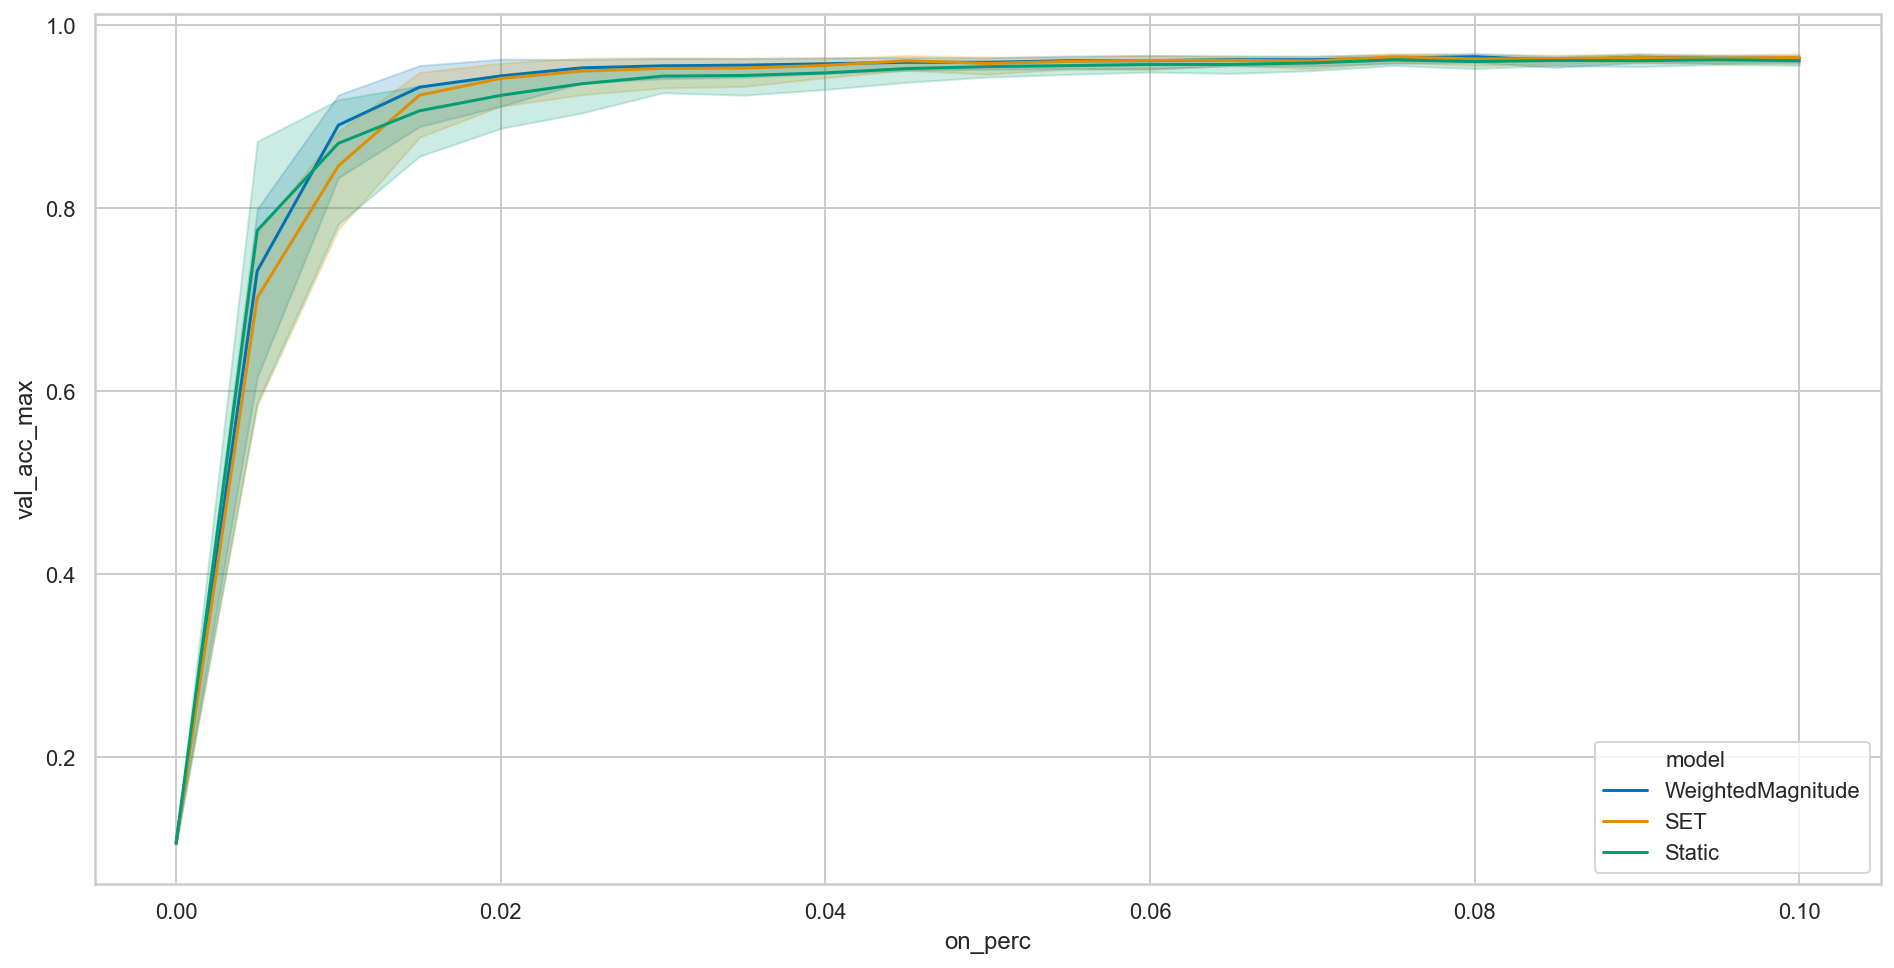

In [18]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')

(0.8, 0.98)

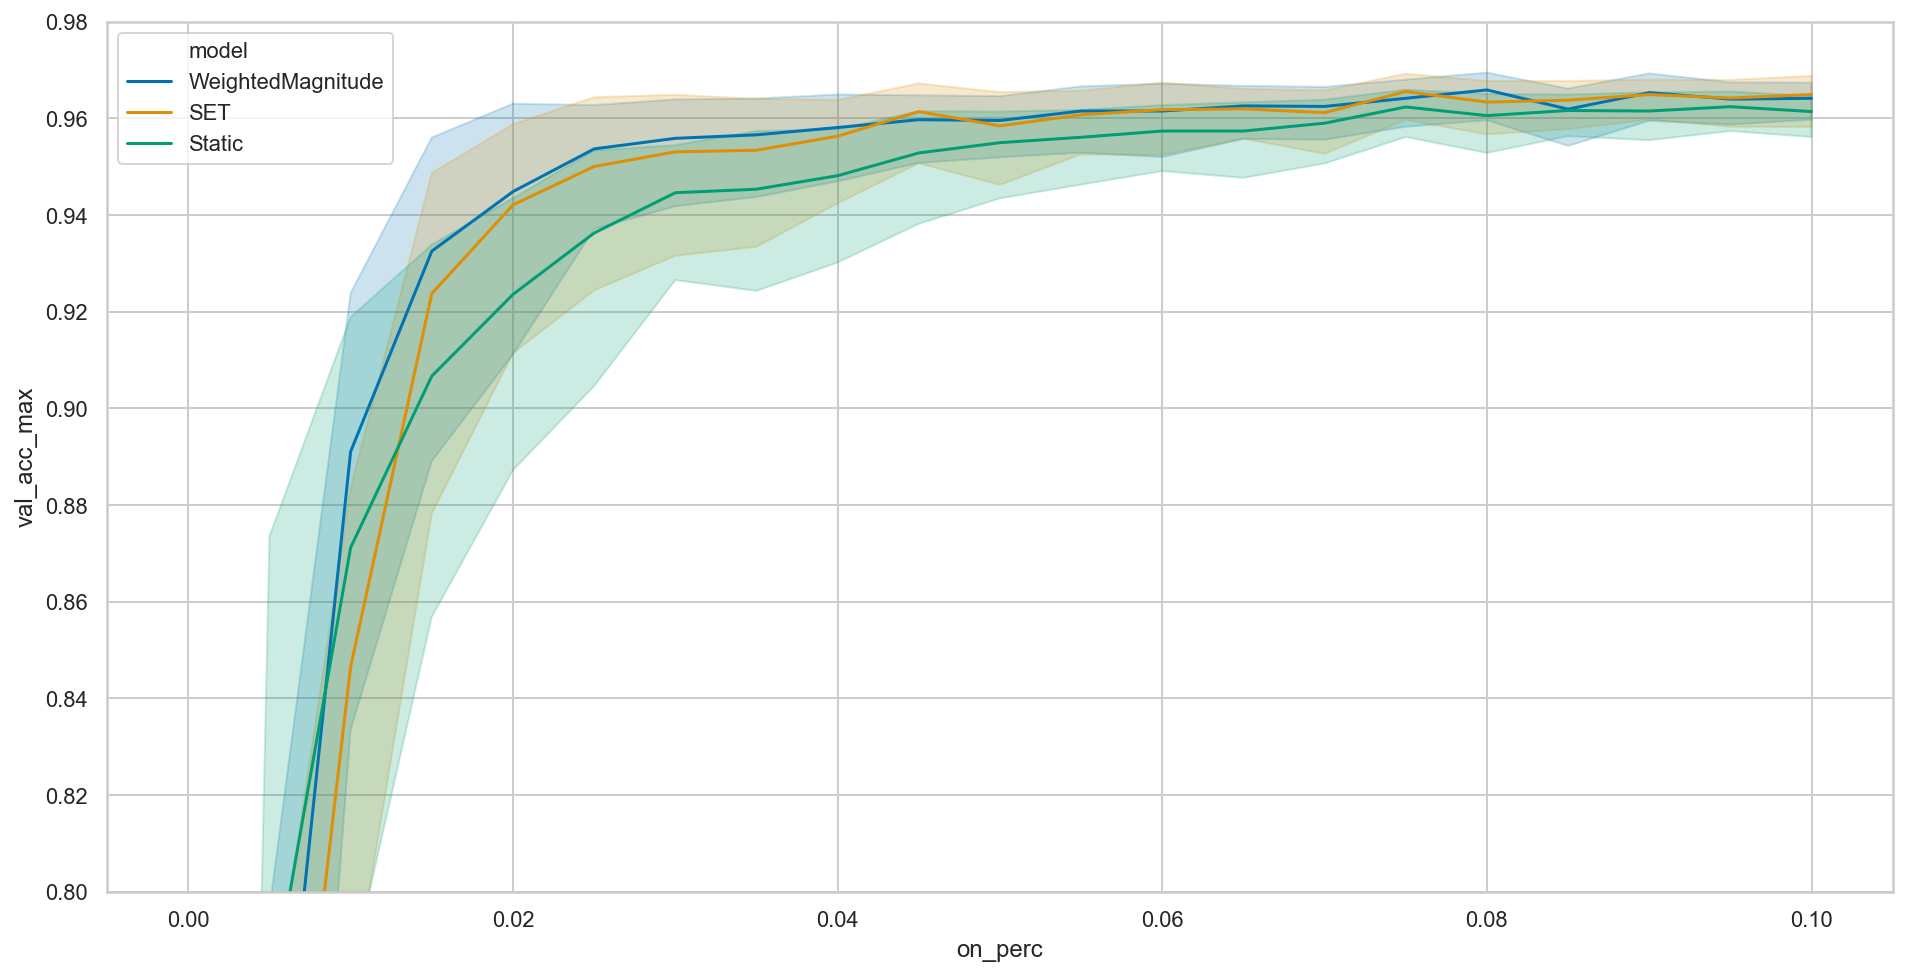

In [19]:
# sns.scatterplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_max', hue='model')
plt.ylim(0.8,0.98)

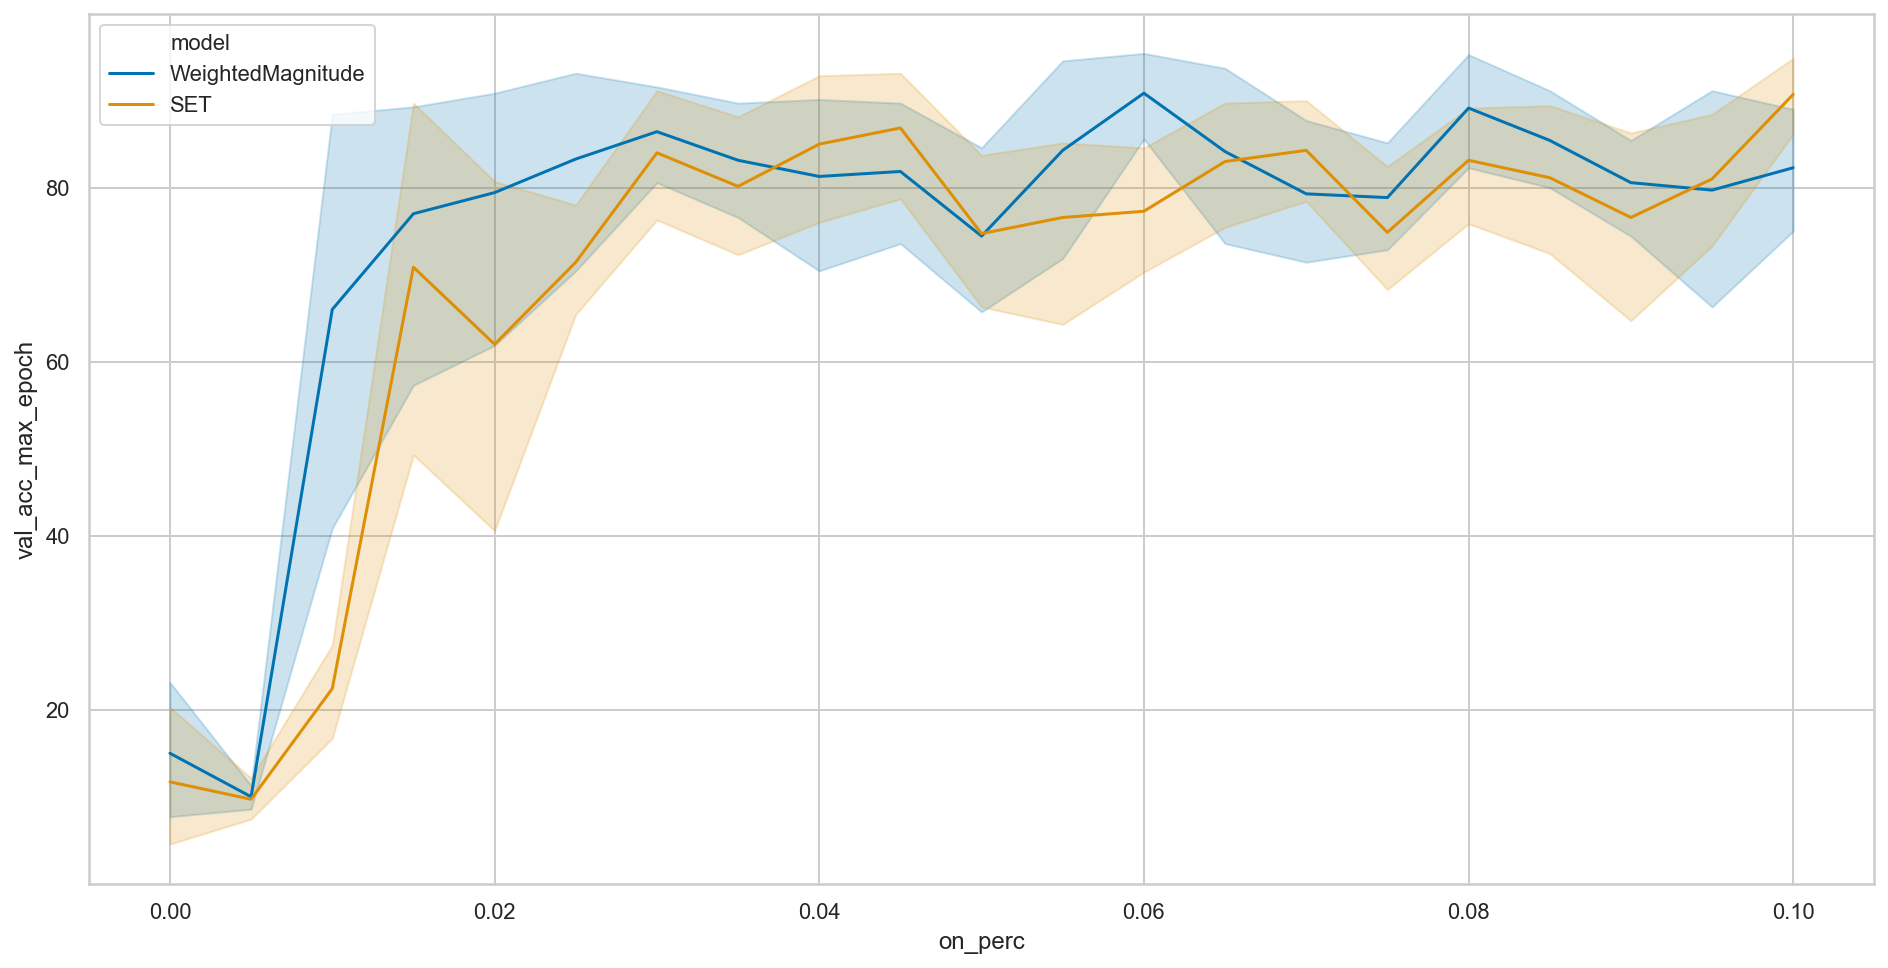

In [20]:
rcParams['figure.figsize'] = 16, 8
filter = df_plot['model'] != 'Static'
sns.lineplot(data=df_plot[filter], x='on_perc', y='val_acc_max_epoch', hue='model')

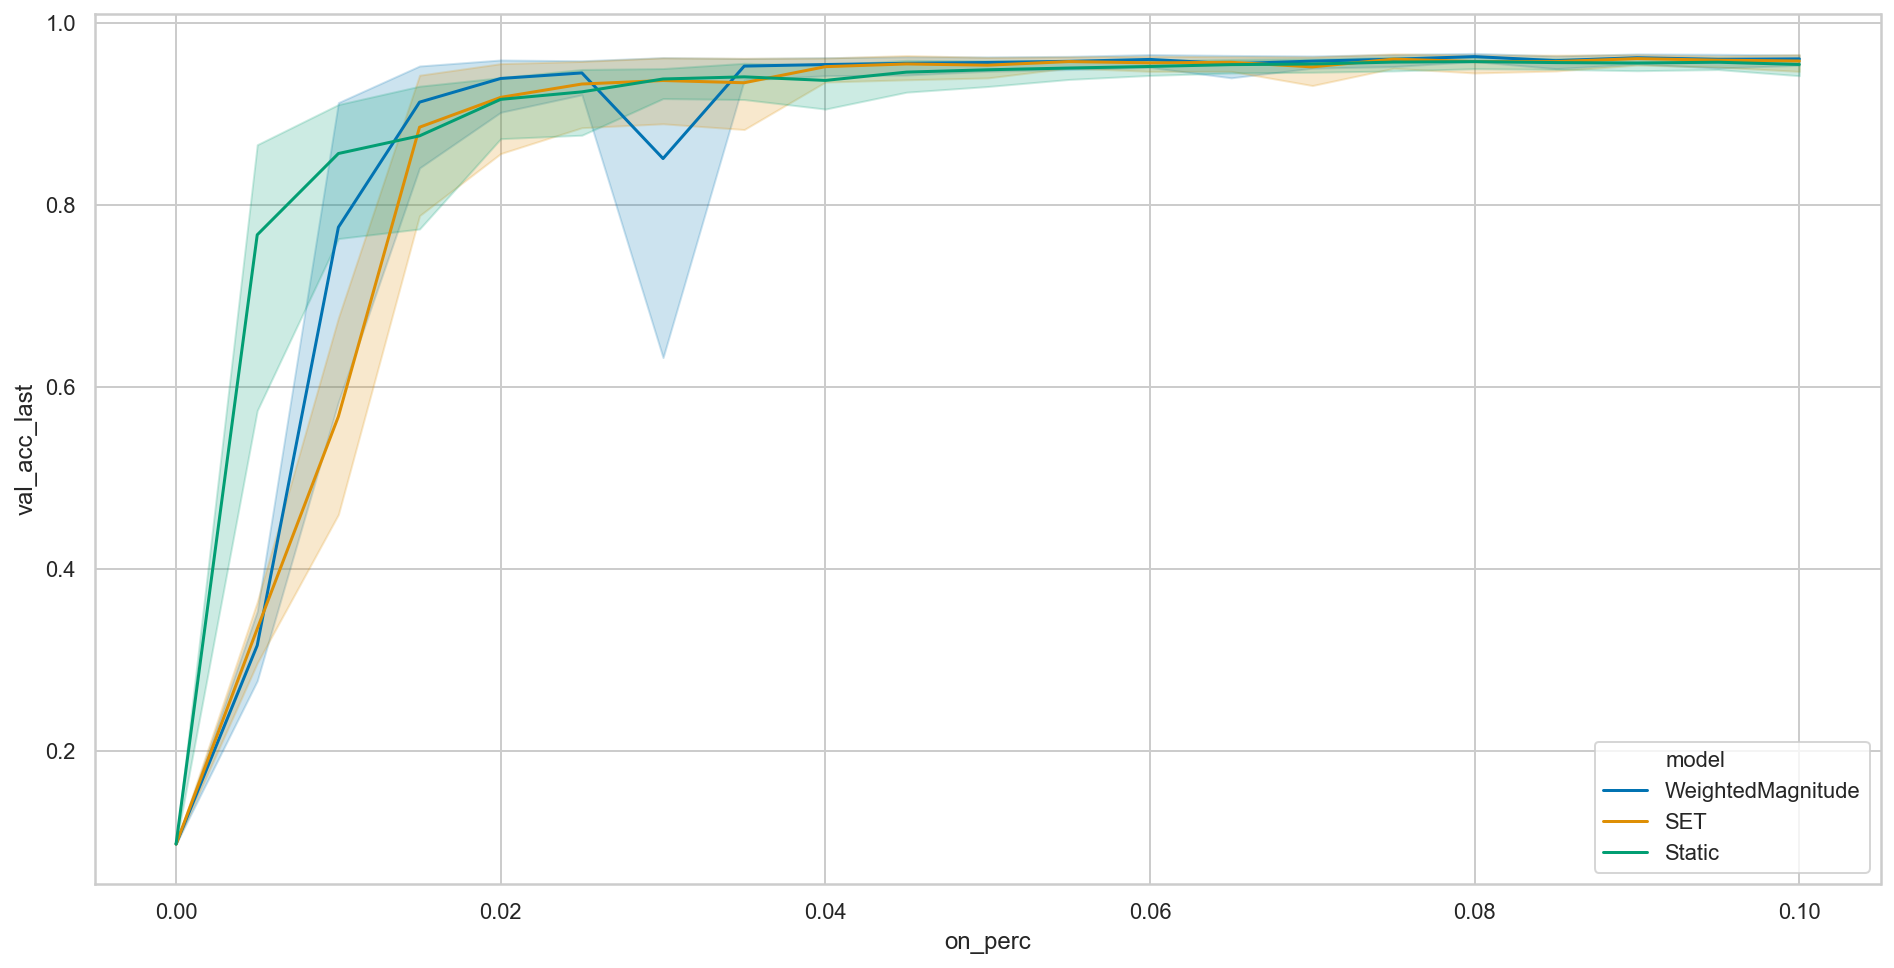

In [21]:
sns.lineplot(data=df_plot, x='on_perc', y='val_acc_last', hue='model')